# Installations

In [30]:
pip install sentencepiece nltk

Note: you may need to restart the kernel to use updated packages.


In [38]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [32]:
import sys
print(sys.executable)

C:\Users\tharu\anaconda3\envs\GPU-Env\python.exe


In [33]:
import sys
!{sys.executable} -m pip install spherecluster

# Imports

In [34]:
import pandas as pd
import sentencepiece as spm
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec

In [35]:
import torch

print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA Available: True
CUDA Device Count: 1
CUDA Device Name: NVIDIA GeForce RTX 4060 Laptop GPU


# Commit to Github

In [5]:
!pwd                # shows your current folder
!git status         # check uncommitted changes
!git add .
!git commit -m "Creating vector representations"
!git push origin main

'pwd' is not recognized as an internal or external command,
operable program or batch file.


On branch main
Your branch is ahead of 'origin/main' by 12 commits.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean


[main c36ea96] Creating vector representations
 7 files changed, 118102 insertions(+), 115366 deletions(-)


remote: error: Trace: 4471ac86bac9111267c2bf81f6b3a515474b2b1274f9aa43aee5f724cc94a8dc        
remote: error: See https://gh.io/lfs for more information.        
remote: error: File svd_lsa.joblib is 131.90 MB; this exceeds GitHub's file size limit of 100.00 MB        
remote: error: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.        
To https://github.com/Starlight0901/Reddit_SriLanka_Social_Insight.git
 ! [remote rejected] main -> main (pre-receive hook declined)
error: failed to push some refs to 'https://github.com/Starlight0901/Reddit_SriLanka_Social_Insight.git'


# Load the saved tokenizer

In [36]:
unigram = spm.SentencePieceProcessor()
unigram.load(r"C:\Users\tharu\Documents\GitHub\Reddit_SriLanka_Social_Insight\unigram.model")  # specify the correct path

# Encode text to token IDs
token_ids = unigram.encode("This is a sample post", out_type=int)

# Decode back to text
text = unigram.decode(token_ids)

print(token_ids)
print(text)

[7, 0, 1632, 5, 7, 652, 512, 745, 4144, 98]
 ⁇ his is a sample post


In [39]:
# Load dataset
df_posts = pd.read_csv("cleaned_Posts_Data.csv")
df_posts.head()

,type,source,keyword,id,author,subreddit,content,score,num_comments,parent_post,created_date,created_time,content_cleaned,word_count
0,post,new,no keyword,1otaemb,Cookiehere6969,srilanka,Is this a Scam or good investment? Haritha Lan...,2.0,1.0,no post,2025-11-10,10:33:16,scam good investment haritha lanka agarwood pl...,33
1,post,new,no keyword,1otaam5,oshan789,srilanka,Villa units for sale in Unawatuna Sri Lanka ! ...,3.0,0.0,no post,2025-11-10,10:26:02,villa unit sale unawatuna sri lanka new projec...,101
2,post,new,no keyword,1ot9h2f,No-Leave8971,srilanka,Need advice from the experts 🙏 [](https://www....,2.0,0.0,no post,2025-11-10,09:33:57,need advice expert folded_hands plan podcast f...,63
3,post,new,no keyword,1ot9dyw,hotstar10,srilanka,Confusion Over Paddock Club Nugegoda’s Halal S...,0.0,4.0,no post,2025-11-10,09:28:19,confusion paddock club nugegoda halal status o...,42
4,post,new,no keyword,1ot9da2,prav_u,srilanka,Tour to Kanneliya Rain Forest I’m planning a g...,1.0,1.0,no post,2025-11-10,09:26:59,tour kanneliya rain forest plan group visit ka...,35


In [40]:
# Encode text to token IDs using the loaded tokenizer
df_posts['tokens'] = df_posts['content_cleaned'].apply(lambda x: unigram.encode(x, out_type=int))

In [41]:
df = df_posts.copy()

# Vectorization in preparation for Modelling 

## Both Posts + Comments

In [42]:
#  Sparse Representations

count_vect = CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)
X_count = count_vect.fit_transform(df['content_cleaned'])
print("Count shape:", X_count.shape)

tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)
X_tfidf = tfidf_vect.fit_transform(df['content_cleaned'])
print("TF-IDF shape:", X_tfidf.shape)

#  Dense: LSA (Truncated SVD)

svd_components = 100
svd = TruncatedSVD(n_components=svd_components, random_state=42)
X_lsa = svd.fit_transform(X_tfidf)
print("LSA shape:", X_lsa.shape)

#  Dense: Word2Vec Embeddings
print("\nTraining Word2Vec model...")

# 1. Tokenize text
documents = df['content_cleaned'].astype(str).apply(lambda x: x.split()).tolist()

# Train Word2Vec
w2v_dim = 300  # embedding dimension
w2v_model = Word2Vec(
    sentences=documents,
    vector_size=w2v_dim,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    epochs=10
)

# 3. Build document embeddings
def doc_vector(words):
    vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(vectors) == 0:
        return np.zeros(w2v_dim)
    return np.mean(vectors, axis=0)

X_w2v = np.array([doc_vector(doc) for doc in documents])
print("Word2Vec shape:", X_w2v.shape)

# Save model
w2v_model.save("word2vec.model")

print("\nAll vector representations generated successfully.")


Count shape: (38209, 214315)
TF-IDF shape: (38209, 214315)
LSA shape: (38209, 100)

Training Word2Vec model...
Word2Vec shape: (38209, 300)

All vector representations generated successfully.


## **Justification of Vector Representations**

### **1. Sparse Representations**

**a) Count Vector (Bag-of-Words)**

* Choice: CountVectorizer with unigrams and bigrams.
* Reason:
  * Captures raw frequency of words/phrases in each document.
  * Bigrams help detect short phrases and context (**“not good”**, **“high risk”**).
  * Sparse format is memory-efficient for high-dimensional data.
* **Dimension:** `(48028, 172884)` → 48k posts × 172k vocabulary features.

**b) TF-IDF Vector**

* **Choice:** TfidfVectorizer with unigrams and bigrams.
* **Reason:**

  * Improves on raw counts by down-weighting very common words and up-weighting discriminative terms.
  * Reduces noise and highlights informative features for clustering/classification.
* **Dimension:** `(48028, 172884)` → same vocabulary, different feature weighting.

### **2. Dense Representations**

**a) LSA (Truncated SVD)**

* **Choice:** Reduce TF-IDF matrix to 100 latent dimensions.
* **Reason:**

  * Captures **latent semantic structure** rather than raw word counts.
  * Reduces dimensionality from 172k → 100, making downstream models faster and less prone to overfitting.
  * Dense vectors allow similarity-based clustering (e.g., KMeans) to work better.
* **Dimension:** `(48028, 100)` → 48k documents × 100 latent features.

**b) Word2Vec (Average Word Embeddings)**

* **Choice:** Train 300-dimensional word embeddings and average per document.
* **Reason:**

  * Captures **semantic meaning** of words and documents, not just frequency.
  * Dense, compact, and suitable for clustering or classification.
  * Complementary to LSA because it uses **contextual similarity** rather than linear algebra on term-frequency.
* **Dimension:** `(48028, 300)` → 48k documents × 300-dimensional dense vectors.


 **Summary Table**

| Representation | Type   | Dimensionality  | Justification                                                                    |
| -------------- | ------ | --------------- | -------------------------------------------------------------------------------- |
| Count          | Sparse | (48028, 172884) | Captures raw term frequency with unigrams + bigrams; good baseline for ML        |
| TF-IDF         | Sparse | (48028, 172884) | Highlights informative terms, reduces noise from frequent words                  |
| LSA            | Dense  | (48028, 100)    | Reduces dimensionality, captures latent semantic structure for better clustering |
| Word2Vec       | Dense  | (48028, 300)    | Captures semantic meaning; dense embeddings improve similarity-based tasks       |


## Posts Only

In [52]:
post_only_df = df.copy()

# Remove rows where source == "comments"
post_only_df = post_only_df[post_only_df["source"] != "comment"]
print("Filtered Data: ",post_only_df.shape)
post_only_df.head(10)

Filtered Data:  (14852, 17)


,type,source,keyword,id,author,subreddit,content,score,num_comments,parent_post,created_date,created_time,content_cleaned,word_count,tokens,category,lda_category
0,post,new,no keyword,1otaemb,Cookiehere6969,srilanka,Is this a Scam or good investment? Haritha Lan...,2.0,1.0,no post,2025-11-10,10:33:16,scam good investment haritha lanka agarwood pl...,33,"[644, 15, 427, 5509, 1643, 13, 2908, 570, 7885...",1,2
1,post,new,no keyword,1otaam5,oshan789,srilanka,Villa units for sale in Unawatuna Sri Lanka ! ...,3.0,0.0,no post,2025-11-10,10:26:02,villa unit sale unawatuna sri lanka new projec...,101,"[3149, 931, 966, 3058, 8, 13, 84, 369, 92, 309...",2,2
2,post,new,no keyword,1ot9h2f,No-Leave8971,srilanka,Need advice from the experts 🙏 [](https://www....,2.0,0.0,no post,2025-11-10,09:33:57,need advice expert folded_hands plan podcast f...,63,"[24, 116, 1233, 1114, 3, 905, 90, 3639, 102, 4...",2,2
3,post,new,no keyword,1ot9dyw,hotstar10,srilanka,Confusion Over Paddock Club Nugegoda’s Halal S...,0.0,4.0,no post,2025-11-10,09:28:19,confusion paddock club nugegoda halal status o...,42,"[6234, 3349, 42, 3520, 1049, 2731, 5913, 1426,...",2,2
4,post,new,no keyword,1ot9da2,prav_u,srilanka,Tour to Kanneliya Rain Forest I’m planning a g...,1.0,1.0,no post,2025-11-10,09:26:59,tour kanneliya rain forest plan group visit ka...,35,"[1204, 64, 316, 152, 975, 1048, 777, 2307, 90,...",2,1
5,post,new,no keyword,1ot8r8a,Unusual-Witness-7304,srilanka,"ChatGPT vs electricians, my house wiring is no...",6.0,5.0,no post,2025-11-10,08:46:44,chatgpt v electrician house wire science exper...,96,"[2567, 370, 6377, 240, 3479, 384, 4228, 3202, ...",1,2
6,post,new,no keyword,1ot8lir,negative-impactr8888,srilanka,SLTMobitel changed the superuser router passwo...,3.0,0.0,no post,2025-11-10,08:36:16,sltmobitel change superuser router password tr...,54,"[480, 1787, 2816, 5624, 120, 671, 788, 56, 100...",1,0
7,post,new,no keyword,1ot8l95,Jakesbond007,srilanka,Can we hand carry medicine from abroad into Sr...,1.0,3.0,no post,2025-11-10,08:35:47,hand carry medicine abroad sri lanka hello med...,26,"[311, 1178, 813, 278, 8, 13, 518, 813, 879, 4,...",2,2
8,post,new,no keyword,1ot8kjb,sorenxv,srilanka,How Do I Get A Letter From Church? My bestfrie...,2.0,2.0,no post,2025-11-10,08:34:33,get letter church bestfriend 's newborn get ba...,37,"[6, 934, 1688, 82, 3208, 37, 5, 84, 6856, 6, 2...",3,2
9,post,new,no keyword,1ot87vn,ScreenshotSmuggler,srilanka,Guess where this video is from. Let's see how ...,21.0,43.0,no post,2025-11-10,08:11:13,guess video let u see far get province distric...,26,"[498, 442, 126, 40, 39, 281, 6, 1967, 1527, 22...",3,2


In [53]:
#  Sparse Representations
count_vect = CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)
count_repr = count_vect.fit_transform(post_only_df['content_cleaned'])
print("Count shape:", count_repr.shape)

tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)
tfidf_repr = tfidf_vect.fit_transform(post_only_df['content_cleaned'])
print("TF-IDF shape:", tfidf_repr.shape)

# Dense vectorizer: LSA (Truncated SVD)
from sklearn.decomposition import TruncatedSVD

svd_components = 100
svd = TruncatedSVD(n_components=svd_components, random_state=42)
lsa_repr = svd.fit_transform(tfidf_repr)
print("LSA shape:", lsa_repr.shape)


# Dense vectorizer: Word2Vec embeddings
from gensim.models import Word2Vec
import numpy as np

print("\nTraining Word2Vec model...")

# Tokenize text
documents = post_only_df['content_cleaned'].astype(str).apply(lambda x: x.split()).tolist()

# Train Word2Vec
w2v_dim = 300
w2v_model = Word2Vec(
    sentences=documents,
    vector_size=w2v_dim,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    epochs=10
)

# Build document embeddings
def doc_vector(words):
    vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(vectors) == 0:
        return np.zeros(w2v_dim)
    return np.mean(vectors, axis=0)

w2v_repr = np.array([doc_vector(doc) for doc in documents])
print("Word2Vec shape:", w2v_repr.shape)

# Save the Word2Vec model
w2v_model.save("word2vec.model")

print("\nAll vector representations generated successfully.")


Count shape: (14852, 97261)
TF-IDF shape: (14852, 97261)
LSA shape: (14852, 100)

Training Word2Vec model...
Word2Vec shape: (14852, 300)

All vector representations generated successfully.


# Categorization of the dataset based on their content by using document clustering

## Categorize the whole dataset (Posts + Comments)

Silhouette Scores: [0.10541504621505737, 0.10072517395019531, 0.1162918284535408, 0.08969226479530334, 0.10017126798629761, 0.10108359903097153, 0.09497769176959991, 0.09497658908367157]


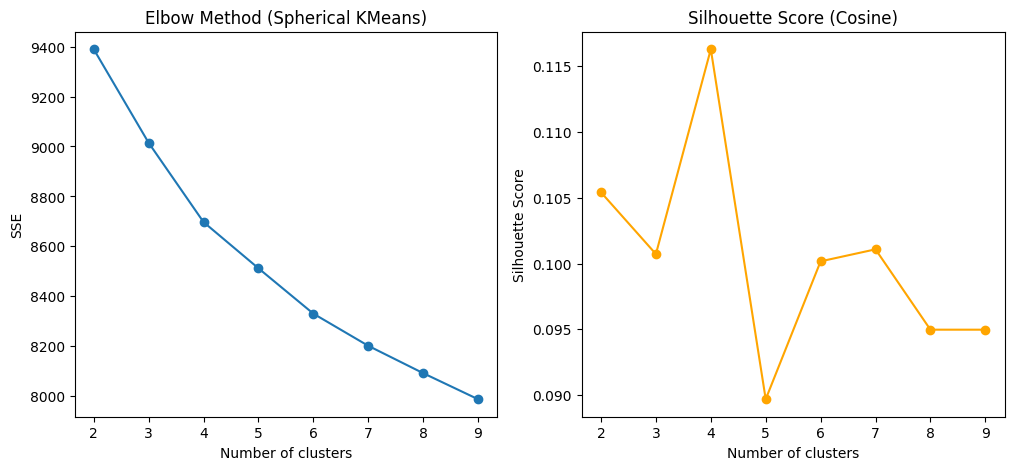

In [43]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Use Word2Vec vectors
X_input = X_w2v  

# Normalize to unit length for spherical k-means
X_norm = normalize(X_input)

sse = []
sil_scores = []
k_values = range(2, 10)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = km.fit_predict(X_norm)
    
    # SSE on normalized vectors
    sse.append(km.inertia_)
    
    # Silhouette score using cosine  metric
    sil_scores.append(silhouette_score(X_norm, labels, metric='cosine'))

print("Silhouette Scores:", sil_scores)

plt.figure(figsize=(12,5))

# Elbow plot
plt.subplot(1,2,1)
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method (Spherical KMeans)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

# Silhouette plot
plt.subplot(1,2,2)
plt.plot(k_values, sil_scores, marker='o', color='orange')
plt.title('Silhouette Score (Cosine)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.show()


Silhouette Scores: [0.10072517395019531, 0.1162918284535408, 0.08969226479530334, 0.10017126798629761, 0.10108359903097153, 0.09497769176959991, 0.09497658908367157, 0.09416915476322174, 0.08197131752967834, 0.08251553773880005, 0.08096795529127121, 0.0844758152961731, 0.08541330695152283, 0.08475485444068909, 0.08316470682621002, 0.08368439227342606, 0.08472193777561188]


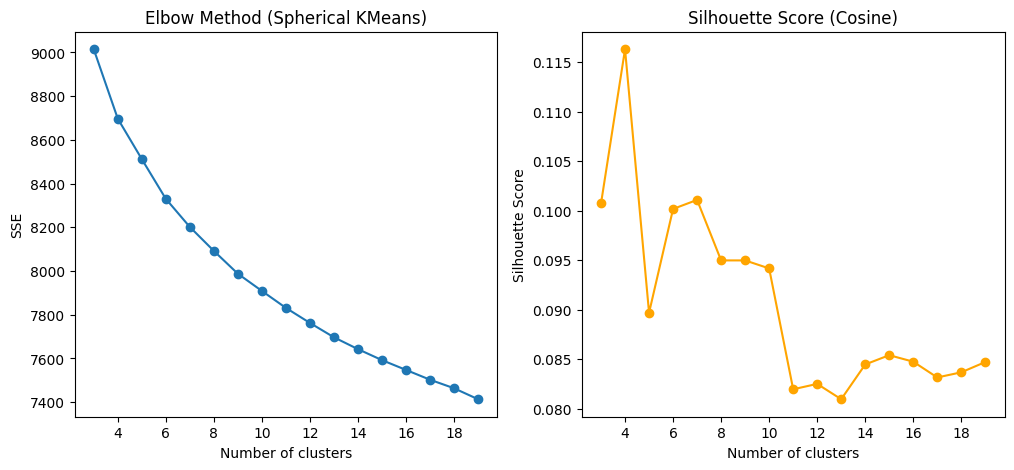

In [44]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Use Word2Vec vectors
X_input = X_w2v  

# Normalize to unit length for spherical k-means
X_norm = normalize(X_input)

sse = []
sil_scores = []
k_values = range(3, 20)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = km.fit_predict(X_norm)
    
    # SSE on normalized vectors
    sse.append(km.inertia_)
    
    # Silhouette score using cosine  metric
    sil_scores.append(silhouette_score(X_norm, labels, metric='cosine'))

print("Silhouette Scores:", sil_scores)

plt.figure(figsize=(12,5))

# Elbow plot
plt.subplot(1,2,1)
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method (Spherical KMeans)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

# Silhouette plot
plt.subplot(1,2,2)
plt.plot(k_values, sil_scores, marker='o', color='orange')
plt.title('Silhouette Score (Cosine)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.show()


Silhouette Scores: [0.10072517395019531, 0.1162918284535408, 0.08969226479530334, 0.10017126798629761, 0.10108359903097153, 0.09505898505449295, 0.09497658908367157, 0.09416915476322174, 0.08197131752967834, 0.08251553773880005, 0.08096795529127121, 0.08447954803705215]


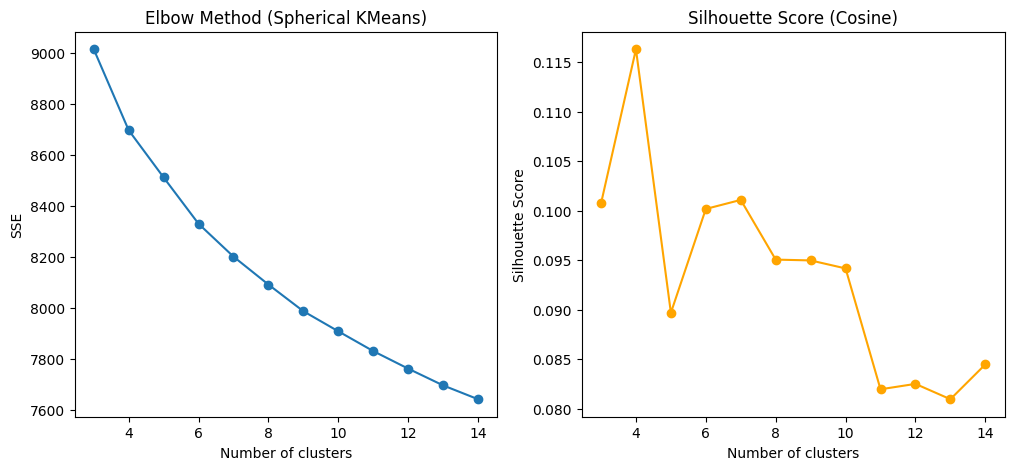

In [45]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Use Word2Vec vectors
X_input = X_w2v  

# Normalize to unit length for spherical k-means
X_norm = normalize(X_input)

sse = []
sil_scores = []
k_values = range(3, 15)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = km.fit_predict(X_norm)
    
    # SSE on normalized vectors
    sse.append(km.inertia_)
    
    # Silhouette score using cosine  metric
    sil_scores.append(silhouette_score(X_norm, labels, metric='cosine'))

print("Silhouette Scores:", sil_scores)

plt.figure(figsize=(12,5))

# Elbow plot
plt.subplot(1,2,1)
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method (Spherical KMeans)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

# Silhouette plot
plt.subplot(1,2,2)
plt.plot(k_values, sil_scores, marker='o', color='orange')
plt.title('Silhouette Score (Cosine)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.show()


In [46]:
best_k = 4 

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_input)

print("Cluster distribution:")
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

Cluster distribution:
{0: 5406, 1: 10724, 2: 7676, 3: 14403}


In [47]:
df['category'] = labels

In [48]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=best_k, random_state=42, learning_method='batch', max_iter=20)
X_lda = lda.fit_transform(X_tfidf)  # document-topic distribution

# Assign dominant topic as category
lda_labels = X_lda.argmax(axis=1)
df['lda_category'] = lda_labels

In [49]:
def print_top_terms(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[-n_top_words:][::-1]]
        print(f"Topic {idx}: {', '.join(top_features)}")

tfidf_feature_names = tfidf_vect.get_feature_names_out()
print_top_terms(lda, tfidf_feature_names)

Topic 0: buy, price, use, car, package, vehicle, dialog, slt, speed, phone
Topic 1: travel, visit, colombo, day, trip, beach, kandy, ella, sri lanka, lanka
Topic 2: sri, get, people, like, go, would, lanka, sri lanka, good, country
Topic 3: match thread, ncpi, match, iia, wicket, th match, run wicket, stream link, send feedback, feedback feedback


In [50]:
df

,type,source,keyword,id,author,subreddit,content,score,num_comments,parent_post,created_date,created_time,content_cleaned,word_count,tokens,category,lda_category
0,post,new,no keyword,1otaemb,Cookiehere6969,srilanka,Is this a Scam or good investment? Haritha Lan...,2.0,1.0,no post,2025-11-10,10:33:16,scam good investment haritha lanka agarwood pl...,33,"[644, 15, 427, 5509, 1643, 13, 2908, 570, 7885...",1,2
1,post,new,no keyword,1otaam5,oshan789,srilanka,Villa units for sale in Unawatuna Sri Lanka ! ...,3.0,0.0,no post,2025-11-10,10:26:02,villa unit sale unawatuna sri lanka new projec...,101,"[3149, 931, 966, 3058, 8, 13, 84, 369, 92, 309...",2,2
2,post,new,no keyword,1ot9h2f,No-Leave8971,srilanka,Need advice from the experts 🙏 [](https://www....,2.0,0.0,no post,2025-11-10,09:33:57,need advice expert folded_hands plan podcast f...,63,"[24, 116, 1233, 1114, 3, 905, 90, 3639, 102, 4...",2,2
3,post,new,no keyword,1ot9dyw,hotstar10,srilanka,Confusion Over Paddock Club Nugegoda’s Halal S...,0.0,4.0,no post,2025-11-10,09:28:19,confusion paddock club nugegoda halal status o...,42,"[6234, 3349, 42, 3520, 1049, 2731, 5913, 1426,...",2,2
4,post,new,no keyword,1ot9da2,prav_u,srilanka,Tour to Kanneliya Rain Forest I’m planning a g...,1.0,1.0,no post,2025-11-10,09:26:59,tour kanneliya rain forest plan group visit ka...,35,"[1204, 64, 316, 152, 975, 1048, 777, 2307, 90,...",2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38204,comment,comment,no keyword,my80nu1,noturtypicalreader,srilanka,"I understand the frustration perfectly well, ...",1.0,NaN,1lcv59f,2025-06-17,06:51:43,understand frustration perfectly well really w...,21,"[211, 3467, 1187, 14, 31, 60, 789, 4457, 3129,...",2,2
38205,comment,comment,no keyword,my8751p,Evening_Ad6130,srilanka,Currently I'm using the Revlon one. I have see...,1.0,NaN,1lcv59f,2025-06-17,07:55:28,currently use revlon one see nice shade lip li...,20,"[221, 28, 475, 559, 247, 282, 16, 39, 539, 445...",2,2
38206,img_post,url,no keyword,1ozh1f2,shxf_1,srilanka,S Post eee\n\n\ Rock solid @ X.com\n@ShitpostR...,3.0,NaN,no post,2025-11-17,14:01:02,post ee rock solid x com shitpostrock n woman ...,40,"[98, 321, 32, 1638, 1160, 404, 941, 275, 3902,...",3,2
38207,img_post,url,no keyword,1ozfhgk,curiouscolombite,srilanka,(4) Namal Rajapaksa @\n1h-@\n\nHQSDOEGS F BSGA...,3.0,NaN,no post,2025-11-17,12:53:36,namal rajapaksa h hqsdoegs f bsgaia ghia semnd...,72,"[1542, 1657, 685, 685, 2085, 5, 601, 3790, 5, ...",0,2


## Categorize the Post Only dataset 

Silhouette Scores: [0.12539929151535034, 0.12913279235363007, 0.15443278849124908, 0.1507108360528946, 0.15676063299179077, 0.14899775385856628, 0.14360596239566803, 0.12948834896087646]


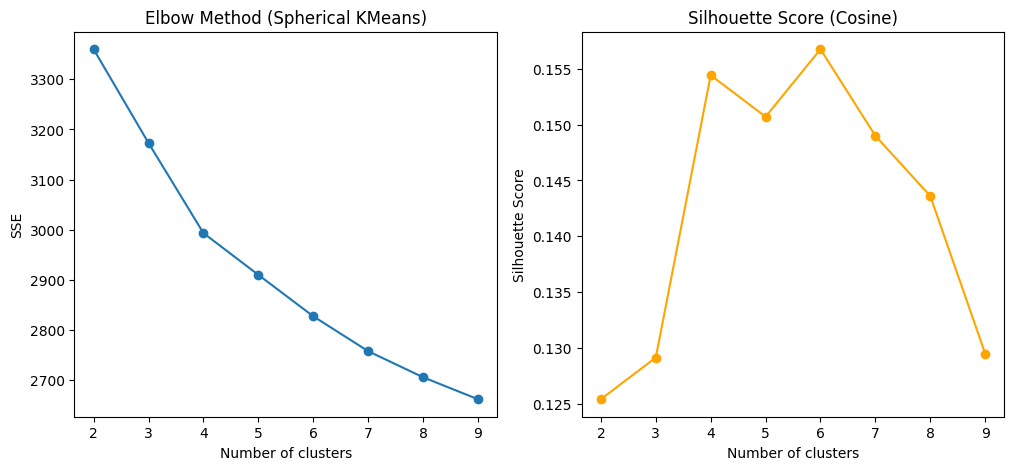

In [54]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Use Word2Vec vectors
X_input = w2v_repr  

# Normalize to unit length for spherical k-means
X_norm = normalize(X_input)

sse = []
sil_scores = []
k_values = range(2, 10)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = km.fit_predict(X_norm)
    
    # SSE on normalized vectors
    sse.append(km.inertia_)
    
    # Silhouette score using cosine  metric
    sil_scores.append(silhouette_score(X_norm, labels, metric='cosine'))

print("Silhouette Scores:", sil_scores)

plt.figure(figsize=(12,5))

# Elbow plot
plt.subplot(1,2,1)
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method (Spherical KMeans)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

# Silhouette plot
plt.subplot(1,2,2)
plt.plot(k_values, sil_scores, marker='o', color='orange')
plt.title('Silhouette Score (Cosine)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.show()


Silhouette Scores: [0.12913279235363007, 0.15443278849124908, 0.1507108360528946, 0.15676063299179077, 0.14899775385856628, 0.14360596239566803, 0.12948834896087646, 0.13433833420276642, 0.12200547754764557, 0.12277248501777649, 0.11870276182889938, 0.11407605558633804, 0.11786595731973648, 0.11653608083724976, 0.11519253998994827, 0.1156410425901413, 0.10915211588144302]


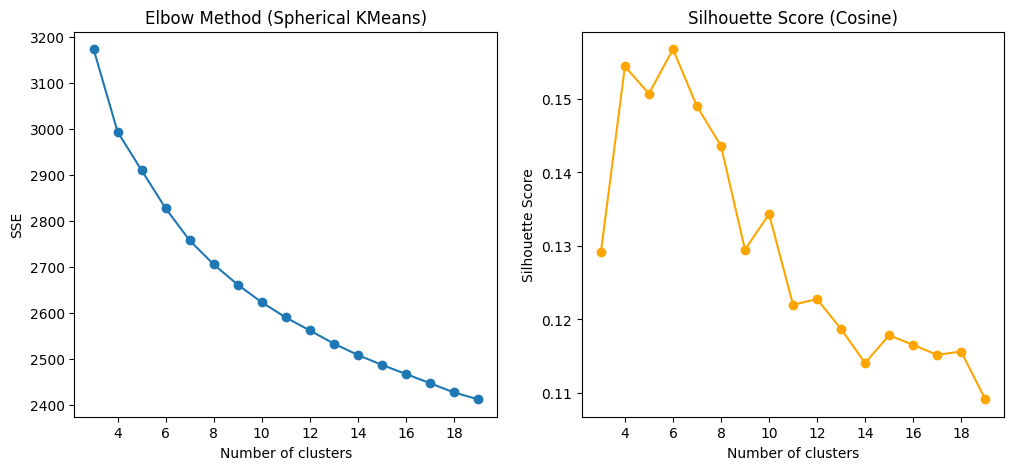

In [56]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Use Word2Vec vectors
X_input = w2v_repr  

# Normalize to unit length for spherical k-means
X_norm = normalize(X_input)

sse = []
sil_scores = []
k_values = range(3, 20)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = km.fit_predict(X_norm)
    
    # SSE on normalized vectors
    sse.append(km.inertia_)
    
    # Silhouette score using cosine  metric
    sil_scores.append(silhouette_score(X_norm, labels, metric='cosine'))

print("Silhouette Scores:", sil_scores)

plt.figure(figsize=(12,5))

# Elbow plot
plt.subplot(1,2,1)
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method (Spherical KMeans)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

# Silhouette plot
plt.subplot(1,2,2)
plt.plot(k_values, sil_scores, marker='o', color='orange')
plt.title('Silhouette Score (Cosine)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.show()

Silhouette Scores: [0.12913279235363007, 0.15443278849124908, 0.1507108360528946, 0.15676063299179077, 0.14899775385856628, 0.14360596239566803, 0.12948834896087646, 0.13433833420276642, 0.12200547754764557, 0.12277248501777649, 0.11870276182889938, 0.11407605558633804]


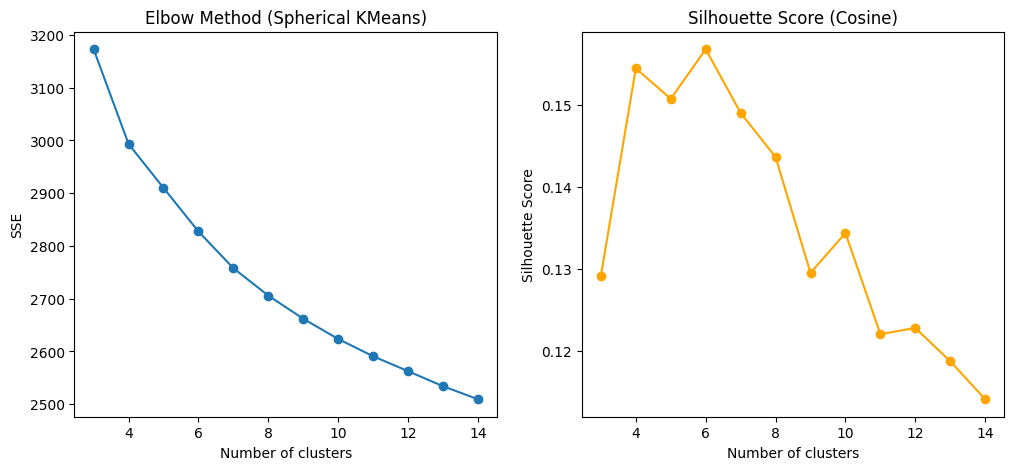

In [57]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Use Word2Vec vectors
X_input = w2v_repr  

# Normalize to unit length for spherical k-means
X_norm = normalize(X_input)

sse = []
sil_scores = []
k_values = range(3, 15)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = km.fit_predict(X_norm)
    
    # SSE on normalized vectors
    sse.append(km.inertia_)
    
    # Silhouette score using cosine  metric
    sil_scores.append(silhouette_score(X_norm, labels, metric='cosine'))

print("Silhouette Scores:", sil_scores)

plt.figure(figsize=(12,5))

# Elbow plot
plt.subplot(1,2,1)
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method (Spherical KMeans)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

# Silhouette plot
plt.subplot(1,2,2)
plt.plot(k_values, sil_scores, marker='o', color='orange')
plt.title('Silhouette Score (Cosine)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.show()


In [64]:
best_k = 6
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(w2v_repr)

post_only_df['category'] = labels

print("Cluster distribution:")
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

Cluster distribution:
{0: 2139, 1: 4622, 2: 652, 3: 2827, 4: 1783, 5: 2829}


In [65]:
post_only_df['category'] = labels

In [66]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(
    n_components=best_k,
    random_state=42,
    learning_method='batch',
    max_iter=20
)
X_lda = lda.fit_transform(tfidf_repr)

# Dominant topic per document
lda_labels = X_lda.argmax(axis=1)
post_only_df['lda_category'] = lda_labels

In [67]:
lda = LatentDirichletAllocation(
    n_components=best_k,
    random_state=42,
    learning_method='batch',
    max_iter=20
)
X_lda = lda.fit_transform(tfidf_repr)  # document-topic distribution

lda_labels = X_lda.argmax(axis=1)
post_only_df['lda_category'] = lda_labels

# ---------------- Print top words per topic ----------------
def print_top_terms(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[-n_top_words:][::-1]]
        print(f"Topic {idx}: {', '.join(top_features)}")

tfidf_feature_names = tfidf_vect.get_feature_names_out()
print_top_terms(lda, tfidf_feature_names)

print("\nAll vector representations and LDA topics generated successfully.")

Topic 0: horton, horton plain, day ella, fortress, pidurangala, minneriya, coffe, ambuluwawa, rock fortress, cola
Topic 1: preferential vote, deactivate, mythology, tuktuks, nasa, cpc, eparcel, discard, mcdonald, litre
Topic 2: sri, lanka, sri lanka, get, would, like, know, go, good, anyone
Topic 3: martial, martial art, koko, pekoe trail, self defense, learn martial, matcha, pekoe, rainforest, neelan
Topic 4: biscuit, fm, dermatologist, deadpool, compound, resource list, giveaway, violin, nissan magnite, magnite
Topic 5: tile, pen, match, match thread, south africa, ice cream, thread, pvr, dolby, halloween

All vector representations and LDA topics generated successfully.


In [70]:
# Word2Vec-based "Topic Modeling" 

# Represent topics by top words closest to cluster centroids

def top_terms_per_cluster(kmeans_model, w2v_model, n_top_words=10):
    centroids = kmeans_model.cluster_centers_
    feature_names = list(w2v_model.wv.key_to_index.keys())
    topics = {}
    
    for cluster_idx, centroid in enumerate(centroids):
        # Compute cosine similarity between centroid and all word vectors
        sims = np.dot(w2v_model.wv.vectors, centroid) / (
            np.linalg.norm(w2v_model.wv.vectors, axis=1) * np.linalg.norm(centroid) + 1e-10
        )
        top_idx = sims.argsort()[-n_top_words:][::-1]
        topics[cluster_idx] = [feature_names[i] for i in top_idx]
    return topics

topics = top_terms_per_cluster(kmeans, w2v_model, n_top_words=10)

# Print top words per cluster/topic
for cluster_idx, words in topics.items():
    print(f"Topic {cluster_idx}: {', '.join(words)}")

# ---------------- Save Word2Vec Model ----------------
w2v_model.save("word2vec.model")

print("\nWord2Vec based semantic topics generated successfully.")


Topic 0: not_hoping, bci, icl, vain, lecturing, archeology, schol, uor, premed, biomed
Topic 1: not_solely, prosperity, weatherwise, ought, demotivates, heterosexual, works, not_jump, secretive, kello
Topic 2: hotspotting, oneload, packege, not_g, nord, updating, sluggish, dtv, gbs, bombarded
Topic 3: playdate, cateract, teak, vigara, bjj, arround, bci, 're, obsessed, adjusted
Topic 4: suggestions, northwest, mirisa, nuwereliya, radisson, rivestone, inly, byee, freshen, departing
Topic 5: pcbs, submitting, quant, uncomplicated, definite, sucker, not_import, inow, remit, contracto

Word2Vec based semantic topics generated successfully.


# A baseline algorithm for classifier evaluation

cuML not found or import failed — using scikit-learn CPU models.
Dataset: 48028 docs, 4 classes.
Building CountVectorizer and TF-IDF...
Count shape: (38422, 138851) TF-IDF shape: (38422, 138851)
Computing TruncatedSVD (LSA) with 100 components ...
LSA shapes: (38422, 100) (9606, 100)
Using existing gensim Word2Vec model.
Word2Vec doc embeddings shapes: (38422, 100) (9606, 100)
Using CPU models (scikit-learn).

=== Vector: Count | sparse=True | shape (train) = (38422, 138851)
MultinomialNB on Count -> acc=0.9198, f1=0.9175, time=0.1s


C:\Users\tharu\anaconda3\envs\torch\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


LogisticRegression on Count -> acc=0.9105, f1=0.9080, time=8.9s
LinearSVC on Count -> acc=0.9064, f1=0.9032, time=4.7s
RandomForest on Count -> acc=0.8302, f1=0.8229, time=150.4s

=== Vector: TFIDF | sparse=True | shape (train) = (38422, 138851)
MultinomialNB on TFIDF -> acc=0.8310, f1=0.8129, time=0.0s


C:\Users\tharu\anaconda3\envs\torch\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


LogisticRegression on TFIDF -> acc=0.9003, f1=0.8971, time=2.1s
LinearSVC on TFIDF -> acc=0.9093, f1=0.9069, time=0.8s
RandomForest on TFIDF -> acc=0.8306, f1=0.8231, time=131.4s

=== Vector: LSA | sparse=False | shape (train) = (38422, 100)
Skipping MultinomialNB for LSA (not supported for dense continuous vectors).


C:\Users\tharu\anaconda3\envs\torch\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


LogisticRegression on LSA -> acc=0.8495, f1=0.8433, time=4.0s
LinearSVC on LSA -> acc=0.8612, f1=0.8569, time=4.2s
RandomForest on LSA -> acc=0.8235, f1=0.8177, time=25.7s

=== Vector: Word2Vec | sparse=False | shape (train) = (38422, 100)
Skipping MultinomialNB for Word2Vec (not supported for dense continuous vectors).


C:\Users\tharu\anaconda3\envs\torch\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


LogisticRegression on Word2Vec -> acc=0.2864, f1=0.2486, time=4.2s
LinearSVC on Word2Vec -> acc=0.2813, f1=0.2483, time=4.0s
RandomForest on Word2Vec -> acc=0.2725, f1=0.2456, time=25.8s

=== Vector: Word2Vec_Spherical | sparse=False | shape (train) = (38422, 100)
Skipping MultinomialNB for Word2Vec_Spherical (not supported for dense continuous vectors).


C:\Users\tharu\anaconda3\envs\torch\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


LogisticRegression on Word2Vec_Spherical -> acc=0.2817, f1=0.2500, time=5.6s
LinearSVC on Word2Vec_Spherical -> acc=0.2808, f1=0.2499, time=3.4s
RandomForest on Word2Vec_Spherical -> acc=0.2725, f1=0.2456, time=27.6s

=== Results summary ===
                Vector               Model  Accuracy  F1_macro      time_s
0                Count       MultinomialNB  0.919842  0.917462    0.051199
1                Count  LogisticRegression  0.910473  0.907962    8.863123
2                TFIDF           LinearSVC  0.909328  0.906888    0.845380
3                Count           LinearSVC  0.906413  0.903232    4.725500
4                TFIDF  LogisticRegression  0.900271  0.897081    2.109998
5                  LSA           LinearSVC  0.861233  0.856917    4.231709
6                  LSA  LogisticRegression  0.849469  0.843348    4.032501
7                TFIDF        RandomForest  0.830627  0.823062  131.386430
8                Count        RandomForest  0.830210  0.822950  150.390138
9       

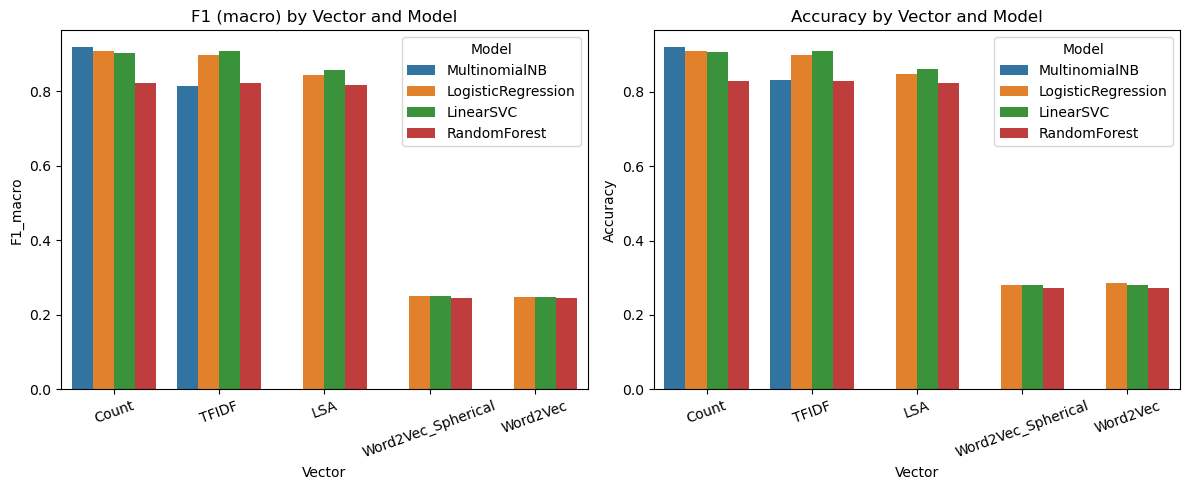


Generating full report for best model: MultinomialNB on Count
Accuracy: 0.9198417655631896
Macro-F1: 0.9174620011494996
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.94      3544
           1       0.92      0.92      0.92      2548
           2       0.92      0.86      0.89      2150
           3       0.93      0.92      0.93      1364

    accuracy                           0.92      9606
   macro avg       0.92      0.91      0.92      9606
weighted avg       0.92      0.92      0.92      9606



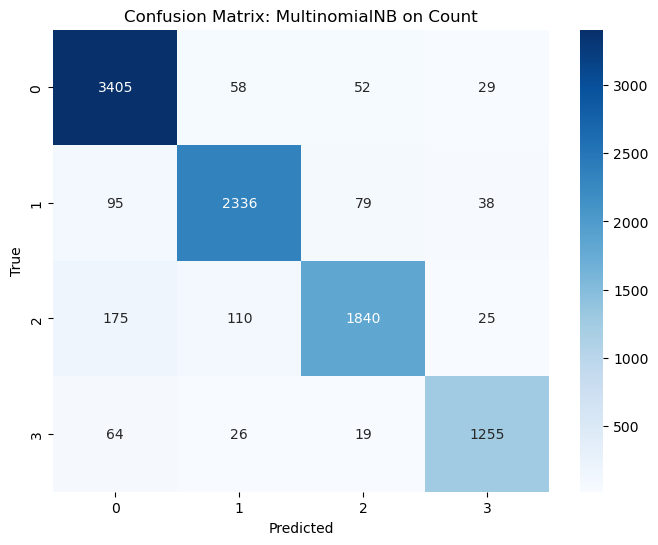

Saved results and vectorizers.


In [88]:
"""
End-to-end classification pipeline with CPU fallback / optional GPU (RAPIDS) acceleration.

Outputs:
- results table (Accuracy, Macro-F1) for every Vectorizer x Model combo
- bar plots of F1 and Accuracy
- confusion matrix for best model
- automatic best-model selection by Macro-F1

Requirements (CPU mode):
  pip install numpy pandas scikit-learn gensim matplotlib seaborn joblib

Optional GPU (RAPIDS) install (conda recommended):
  See RAPIDS install guide for your CUDA version, e.g.:
  conda create -n rapids -c rapidsai -c nvidia -c conda-forge cuml cudf python=3.10 cudatoolkit=12.0
  conda activate rapids

"""

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

# sklearn components
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# sklearn models (CPU fallback)
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# gensim Word2Vec (optional)
try:
    from gensim.models import Word2Vec
    gensim_available = True
except Exception:
    gensim_available = False

# Try to import RAPIDS (cuML / cudf / cupy). If available, we'll use GPU models.
use_gpu = False
try:
    import cudf
    import cupy as cp
    from cuml.naive_bayes import MultinomialNB as cuMultinomialNB
    from cuml.linear_model import LogisticRegression as cuLogisticRegression
    from cuml.svm import SVC as cuSVC
    from cuml.ensemble import RandomForestClassifier as cuRandomForest
    from cuml.metrics import accuracy_score as cu_accuracy_score
    # If imports succeed, set flag
    use_gpu = True
    print("cuML detected — GPU models will be used where appropriate.")
except Exception:
    print("cuML not found or import failed — using scikit-learn CPU models.")

# --------------------------
# User-provided dataset
# --------------------------
# Ensure df_posts exists and has 'content_cleaned' column and 'label' column (labels from your clustering)
# if 'df_posts' not in globals():
#     raise RuntimeError("Please load your dataframe into variable `df_posts` with columns 'content_cleaned' and 'label' before running.")

# df = df_posts.copy()
if 'content_cleaned' not in df.columns:
    raise RuntimeError("Dataframe must contain 'content_cleaned' column with cleaned text.")
if 'category' not in df.columns:
    raise RuntimeError("Dataframe must contain 'category' column (use your clustering categorys as ground-truth).")

# Optional: small sanity-check (remove empty/NaN rows)
df['content_cleaned'] = df['content_cleaned'].astype(str).str.strip()
df = df[~df['content_cleaned'].isna() & (df['content_cleaned'] != '')].reset_index(drop=True)

# --------------------------
# Train/test split
# --------------------------
X_text = df['content_cleaned'].values
y = df['category'].values
print(f"Dataset: {len(X_text)} docs, {len(np.unique(y))} classes.")

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.20, stratify=y, random_state=42
)

# --------------------------
# 1) Sparse vectorizers: Count & TF-IDF
# --------------------------
print("Building CountVectorizer and TF-IDF...")
count_vect = CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)
X_train_count = count_vect.fit_transform(X_train_text)
X_test_count = count_vect.transform(X_test_text)

tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)
X_train_tfidf = tfidf_vect.fit_transform(X_train_text)
X_test_tfidf = tfidf_vect.transform(X_test_text)

print("Count shape:", X_train_count.shape, "TF-IDF shape:", X_train_tfidf.shape)

# --------------------------
# 2) Dense representation 1: LSA (TruncatedSVD on TF-IDF)
# --------------------------
lsa_components = 100
print(f"Computing TruncatedSVD (LSA) with {lsa_components} components ...")
svd = TruncatedSVD(n_components=lsa_components, random_state=42)
X_train_lsa = svd.fit_transform(X_train_tfidf)
X_test_lsa = svd.transform(X_test_tfidf)
print("LSA shapes:", X_train_lsa.shape, X_test_lsa.shape)

# --------------------------
# 3) Dense representation 2: Word2Vec averaged embeddings
# --------------------------
w2v_dim = 300
w2v_model = None

# Try to reuse existing gensim model (if the user has variable w2v_model defined)
if 'w2v_model' in globals():
    w2v_model = globals()['w2v_model']
    print("Using existing gensim Word2Vec model.")
else:
    if not gensim_available:
        print("gensim not available; Word2Vec will be approximated with TF-IDF-weighted mean (fallback).")
    else:
        # Train a small Word2Vec on training texts (can be slow if large)
        print("Training Word2Vec on training corpus (this uses CPU gensim).")
        tokenized = [t.split() for t in X_train_text]
        w2v_model = Word2Vec(sentences=tokenized, vector_size=w2v_dim, window=5, min_count=2, workers=4, sg=1, epochs=10)
        print("Word2Vec trained.")

# Build doc embeddings (average word vectors). If gensim not available, fallback to TF-IDF-weighted mean on dense TF-IDF components.
def get_w2v_embeddings(texts, model, size):
    if model is not None:
        out = []
        for doc in texts:
            toks = [w for w in doc.split() if w in model.wv]
            if len(toks) == 0:
                out.append(np.zeros(size, dtype=np.float32))
            else:
                out.append(np.mean(model.wv[toks], axis=0).astype(np.float32))
        return np.vstack(out)
    else:
        # Fallback: use SVD projection as proxy (use LSA)
        print("Warning: gensim Word2Vec not available — using LSA vectors as fallback for word2vec embeddings.")
        return np.vstack([X_train_lsa, X_test_lsa])[:len(texts)]  # should not happen normally

# compute
X_train_w2v = get_w2v_embeddings(X_train_text, w2v_model, w2v_dim)
X_test_w2v = get_w2v_embeddings(X_test_text, w2v_model, w2v_dim)
print("Word2Vec doc embeddings shapes:", X_train_w2v.shape, X_test_w2v.shape)

# Normalize for spherical variants
X_train_w2v_sph = normalize(X_train_w2v)
X_test_w2v_sph = normalize(X_test_w2v)

# --------------------------
# 4) Prepare models (CPU vs GPU)
# --------------------------
# Define model factories: each entry returns an instantiated model for CPU or GPU depending on use_gpu flag.
def make_cpu_models():
    return {
        "MultinomialNB": MultinomialNB(),
        "LogisticRegression": LogisticRegression(max_iter=1000, solver='liblinear'),
        "LinearSVC": LinearSVC(max_iter=5000),
        "RandomForest": RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
    }

def make_gpu_models():
    # cuML models have slightly different APIs; they operate on cudf/cupy data structures.
    return {
        "MultinomialNB": cuMultinomialNB(),
        "LogisticRegression": cuLogisticRegression(max_iter=1000),
        "LinearSVC": cuSVC(kernel='linear'),  # SVC from cuML
        "RandomForest": cuRandomForest(n_estimators=200, random_state=42)
    }

if use_gpu:
    print("Using GPU models (cuML).")
    models_dict = make_gpu_models()
else:
    print("Using CPU models (scikit-learn).")
    models_dict = make_cpu_models()

# --------------------------
# 5) Data conversions for GPU if available
# --------------------------
def to_gpu_cudf_df(X_np):
    """Convert numpy array to cudf DataFrame for cuML (dense arrays only)."""
    if not use_gpu:
        raise RuntimeError("GPU not enabled")
    import cudf
    # X_np must be 2D numpy
    df_gpu = cudf.DataFrame.from_records(X_np)
    return df_gpu

def to_gpu_csr(X_sparse):
    """Convert scipy sparse to cupy / cudf if needed - for cuML many models accept dense or cudf.
    For large sparse features (TF-IDF) cuML algorithms may not accept sparse; avoid GPU for MultinomialNB on huge sparse matrices."""
    # This script will not convert sparse TF-IDF to GPU; for TF-IDF we will use CPU models.
    raise NotImplementedError("This script uses CPU for sparse matrices (Count/TF-IDF) by default. Convert manually if you need GPU for sparse data.")

# --------------------------
# 6) Define evaluation routine (handles CPU & GPU models)
# --------------------------
def evaluate_model(model_name, model, Xtr, Xte, ytr, yte, is_sparse=False):
    """Train & evaluate single model. Returns metrics dict."""
    start = time.time()
    if use_gpu:
        # cuML models expect cudf DataFrame or cupy arrays
        try:
            if is_sparse:
                # for simplicity, run sparse -> CPU sklearn version (cuML sparse support limited)
                raise RuntimeError("Running sparse models on CPU because GPU sparse conversion not implemented.")
            else:
                # dense numpy -> cudf DataFrame
                Xtr_gpu = cudf.DataFrame.from_records(Xtr) if isinstance(Xtr, np.ndarray) else cudf.DataFrame.from_records(Xtr.toarray())
                Xte_gpu = cudf.DataFrame.from_records(Xte) if isinstance(Xte, np.ndarray) else cudf.DataFrame.from_records(Xte.toarray())
                ytr_gpu = cudf.Series(ytr)
                # fit
                model.fit(Xtr_gpu, ytr_gpu)
                preds_gpu = model.predict(Xte_gpu)
                # convert to numpy
                try:
                    preds = preds_gpu.to_pandas().values
                except Exception:
                    # sometimes cuml returns numpy directly
                    preds = np.array(preds_gpu)
        except Exception as e:
            print("GPU evaluation fallback to CPU due to:", e)
            # convert to CPU sklearn equivalent by re-instantiating CPU model
            cpu_models = make_cpu_models()
            cpu_model = cpu_models[model_name]
            if hasattr(Xtr, 'toarray'):
                Xtr_cpu = Xtr.toarray()
                Xte_cpu = Xte.toarray()
            else:
                Xtr_cpu = np.asarray(Xtr)
                Xte_cpu = np.asarray(Xte)
            cpu_model.fit(Xtr_cpu, ytr)
            preds = cpu_model.predict(Xte_cpu)
    else:
        # CPU scikit-learn
        if is_sparse:
            model.fit(Xtr, ytr)
            preds = model.predict(Xte)
        else:
            model.fit(Xtr, ytr)
            preds = model.predict(Xte)
    elapsed = time.time() - start
    acc = accuracy_score(yte, preds)
    f1 = f1_score(yte, preds, average='macro')
    return {"model_name": model_name, "accuracy": acc, "f1": f1, "time_s": elapsed, "preds": preds}

# --------------------------
# 7) Run experiments across vectorizers and models
# --------------------------
# We'll run:
# - For sparse: Count and TF-IDF we use CPU models (MultinomialNB needs sparse)
# - For dense: LSA (dense) and Word2Vec (dense) use GPU models if available

vector_spaces = {
    "Count": {"Xtr": X_train_count, "Xte": X_test_count, "is_sparse": True},
    "TFIDF": {"Xtr": X_train_tfidf, "Xte": X_test_tfidf, "is_sparse": True},
    "LSA": {"Xtr": X_train_lsa, "Xte": X_test_lsa, "is_sparse": False},
    "Word2Vec": {"Xtr": X_train_w2v, "Xte": X_test_w2v, "is_sparse": False},
    "Word2Vec_Spherical": {"Xtr": X_train_w2v_sph, "Xte": X_test_w2v_sph, "is_sparse": False}
}

results = []
detailed_reports = {}

for vec_name, data in vector_spaces.items():
    Xtr = data["Xtr"]
    Xte = data["Xte"]
    is_sparse = data["is_sparse"]
    print(f"\n=== Vector: {vec_name} | sparse={is_sparse} | shape (train) = {getattr(Xtr,'shape',None)}")
    for model_name, model_obj in models_dict.items():
        # Skip MultinomialNB on dense data (it expects counts)
        if model_name == "MultinomialNB" and not is_sparse:
            print(f"Skipping {model_name} for {vec_name} (not supported for dense continuous vectors).")
            continue
        # For TFIDF/Count keep on CPU (sparse). If use_gpu and data is dense, we'll try GPU.
        try:
            metrics = evaluate_model(model_name, model_obj, Xtr, Xte, y_train, y_test, is_sparse=is_sparse)
            results.append([vec_name, model_name, metrics["accuracy"], metrics["f1"], metrics["time_s"]])
            detailed_reports[(vec_name, model_name)] = metrics
            print(f"{model_name} on {vec_name} -> acc={metrics['accuracy']:.4f}, f1={metrics['f1']:.4f}, time={metrics['time_s']:.1f}s")
        except Exception as e:
            print("Error with", vec_name, model_name, ":", e)

# --------------------------
# 8) Results table & best model selection
# --------------------------
df_results = pd.DataFrame(results, columns=["Vector", "Model", "Accuracy", "F1_macro", "time_s"])
df_results = df_results.sort_values(["F1_macro"], ascending=False).reset_index(drop=True)
print("\n=== Results summary ===")
print(df_results)

best_row = df_results.iloc[0]
print("\nBEST MODEL:", best_row.to_dict())

# --------------------------
# 9) Plots
# --------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.barplot(x="Vector", y="F1_macro", hue="Model", data=df_results)
plt.title("F1 (macro) by Vector and Model")
plt.xticks(rotation=20)

plt.subplot(1,2,2)
sns.barplot(x="Vector", y="Accuracy", hue="Model", data=df_results)
plt.title("Accuracy by Vector and Model")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# --------------------------
# 10) Show confusion matrix & classification report for best model
# --------------------------
best_vector = best_row["Vector"]
best_model = best_row["Model"]
print(f"\nGenerating full report for best model: {best_model} on {best_vector}")

metrics = detailed_reports[(best_vector, best_model)]
preds = metrics["preds"]
print("Accuracy:", metrics["accuracy"])
print("Macro-F1:", metrics["f1"])
print("Classification Report:\n", classification_report(y_test, preds, zero_division=0))

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix: {best_model} on {best_vector}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --------------------------
# 11) Save results
# --------------------------
df_results.to_csv("classification_results_summary.csv", index=False)
dump(tfidf_vect, "tfidf_vect.joblib")
dump(count_vect, "count_vect.joblib")
if w2v_model is not None and hasattr(w2v_model, "save"):
    w2v_model.save("word2vec_model.bin")
print("Saved results and vectorizers.")


# Non-Transformer deep learning models for potentially improved classification

In [93]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [95]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

import torch
torch.cuda.is_available(), torch.cuda.get_device_name(0)

TensorFlow version: 2.20.0
Num GPUs Available: 0


(True, 'NVIDIA GeForce RTX 4060 Laptop GPU')

In [ ]:
"""
Deep Learning Classification Pipeline for Posts (Non-Transformer Models)

Requirements:
pip install tensorflow numpy pandas scikit-learn matplotlib seaborn gensim
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Bidirectional, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# --------------------------
# Dataset
# --------------------------

df['content_cleaned'] = df['content_cleaned'].astype(str).str.strip()
df = df[~df['content_cleaned'].isna() & (df['content_cleaned'] != '')].reset_index(drop=True)

X_text = df['content_cleaned'].values
y_raw = df['category'].values

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y_raw)
num_classes = len(le.classes_)

# Train-test split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)

# --------------------------
# Text preprocessing for DL
# --------------------------
max_words = 20000  # vocabulary size
max_len = 200      # max sequence length

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_text)

X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# --------------------------
# Optional: Pretrained Word2Vec embedding
# --------------------------
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.random.normal(size=(max_words, embedding_dim))

if 'w2v_model' in globals() and w2v_model is not None:
    for word, i in word_index.items():
        if i >= max_words:
            continue
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]

# --------------------------
# Helper function: compile and train
# --------------------------
def train_dl_model(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=64):
    print("Model: ", model)
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )
    return history

# --------------------------
# 1) Feedforward Neural Network (TF-IDF / LSA features)
# --------------------------
# We'll reuse LSA or TF-IDF dense vectors
X_train_dense = X_train_lsa  # or X_train_tfidf.toarray()
X_test_dense = X_test_lsa    # or X_test_tfidf.toarray()

ffnn_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
ffnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ffnn_history = train_dl_model(ffnn_model, X_train_dense, y_train, X_test_dense, y_test, epochs=20)

# --------------------------
# 2) 1D CNN over word sequences
# --------------------------
cnn_model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_history = train_dl_model(cnn_model, X_train_pad, y_train, X_test_pad, y_test, epochs=20)

# --------------------------
# 3) BiLSTM over word sequences
# --------------------------
bilstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
bilstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bilstm_history = train_dl_model(bilstm_model, X_train_pad, y_train, X_test_pad, y_test, epochs=20)

# --------------------------
# 4) Evaluate & compare
# --------------------------
dl_models = {
    "FFNN": (ffnn_model, X_test_dense),
    "CNN": (cnn_model, X_test_pad),
    "BiLSTM": (bilstm_model, X_test_pad)
}

dl_results = []
for name, (model, X_te) in dl_models.items():
    y_pred = np.argmax(model.predict(X_te), axis=1)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    dl_results.append([name, acc, f1])
    print(f"\n{name} -> Accuracy: {acc:.4f}, Macro-F1: {f1:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))

df_dl_results = pd.DataFrame(dl_results, columns=['Model', 'Accuracy', 'F1_macro'])
print("\nDeep Learning Results Summary")
print(df_dl_results)

# --------------------------
# 5) Plot comparison with non-DL models
# --------------------------
plt.figure(figsize=(10,5))
sns.barplot(x='Model', y='F1_macro', data=df_dl_results)
plt.title("Deep Learning Models: Macro-F1")
plt.show()

# Optional: compare side-by-side with df_results from non-DL models
df_combined = pd.concat([
    df_results[['Model', 'F1_macro']].rename(columns={'F1_macro': 'F1_macro_nonDL'}),
    df_dl_results[['Model', 'F1_macro']].rename(columns={'F1_macro': 'F1_macro_DL'})
], axis=1)


Model:  <Sequential name=sequential_6, built=True>
Epoch 1/20


C:\Users\tharu\anaconda3\envs\torch\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


601/601 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.7673 - loss: 0.5878 - val_accuracy: 0.8618 - val_loss: 0.3516
Epoch 2/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8491 - loss: 0.3850 - val_accuracy: 0.8647 - val_loss: 0.3449
Epoch 3/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8555 - loss: 0.3673 - val_accuracy: 0.8641 - val_loss: 0.3384
Epoch 4/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8612 - loss: 0.3560 - val_accuracy: 0.8683 - val_loss: 0.3327
Epoch 5/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8648 - loss: 0.3475 - val_accuracy: 0.8674 - val_loss: 0.3295
Epoch 6/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8674 - loss: 0.3379 - val_accuracy: 0.8687 - val_loss: 0.3274
Epoch 7/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8706 - loss: 0.3283 - val_accuracy: 0.8709 - val_loss: 0.3240
Epoch 8/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8748 - loss: 0.3195 - val_accuracy: 0.8688 - val

C:\Users\tharu\anaconda3\envs\torch\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


601/601 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.5300 - loss: 1.1341 - val_accuracy: 0.6910 - val_loss: 0.7849
Epoch 2/20
239/601 ━━━━━━━━━━━━━━━━━━━━ 25s 69ms/step - accuracy: 0.7098 - loss: 0.7455

# Experimenting with transformer models

## Encoder-only transformer models

In [ ]:
# Assumes: df_posts with columns 'content_cleaned' and 'label'
# Install: pip install transformers datasets scikit-learn evaluate

from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

def get_embeddings(model_name, texts, batch_size=64, device='cuda'):
    tok = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device).eval()
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tok(batch, padding=True, truncation=True, return_tensors='pt', max_length=256).to(device)
            out = model(**enc)
            # take pooled output / CLS
            if hasattr(out, 'pooler_output') and out.pooler_output is not None:
                vec = out.pooler_output.cpu().numpy()
            else:
                # mean-pool last_hidden_state
                vec = out.last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.append(vec)
    return np.vstack(embeddings)

# Example use:
texts = df_posts['content_cleaned'].tolist()
labels = df_posts['label'].values
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, stratify=labels, random_state=42)

# get embeddings for distilbert and roberta
emb_train_rb = get_embeddings('facebook/roberta-large', X_train)
emb_test_rb  = get_embeddings('facebook/roberta-large', X_test)
emb_train_db = get_embeddings('distilbert-base-uncased', X_train)
emb_test_db  = get_embeddings('distilbert-base-uncased', X_test)

# train simple logistic on top
clf_rb = LogisticRegression(max_iter=2000).fit(emb_train_rb, y_train)
pred_rb = clf_rb.predict(emb_test_rb)
print('RoBERTa (features) Acc, F1:', accuracy_score(y_test, pred_rb), f1_score(y_test, pred_rb, average='macro'))

clf_db = LogisticRegression(max_iter=2000).fit(emb_train_db, y_train)
pred_db = clf_db.predict(emb_test_db)
print('DistilBERT (features) Acc, F1:', accuracy_score(y_test, pred_db), f1_score(y_test, pred_db, average='macro'))

In [ ]:
# pip install transformers datasets evaluate accelerate

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np

# prepare dataset
train_ds = Dataset.from_pandas(pd.DataFrame({'text': X_train, 'label': y_train}))
test_ds  = Dataset.from_pandas(pd.DataFrame({'text': X_test, 'label': y_test}))

model_name = 'roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize_fn(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=256)

train_ds = train_ds.map(tokenize_fn, batched=True)
test_ds  = test_ds.map(tokenize_fn, batched=True)
cols = ['input_ids','attention_mask','label']

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(np.unique(labels)))

training_args = TrainingArguments(
    output_dir='./roberta_finetune',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    fp16=True,                 # mixed precision on CUDA
    num_train_epochs=3,
    learning_rate=2e-5,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
)

import evaluate
f1 = evaluate.load('f1')
acc = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {'accuracy': acc.compute(predictions=preds, references=labels)['accuracy'],
            'f1': f1.compute(predictions=preds, references=labels, average='macro')['f1']}

trainer = Trainer(model=model, args=training_args, train_dataset=train_ds.remove_columns(['text']), eval_dataset=test_ds.remove_columns(['text']), compute_metrics=compute_metrics)
trainer.train()
res = trainer.evaluate()
print(res)

In [ ]:
You are a text classifier. Allowed labels: [News, Sports, Tech, Religion]. 
Answer with exactly one label from the list.

Post:
"the post text here..."

Label:


In [ ]:
You are a text classifier. Allowed labels: [News, Sports, Tech, Religion]. Answer with exactly one label.

Example 1:
Post: "..." 
Label: News

Example 2:
Post: "..."
Label: Sports

Example 3:
Post: "..."
Label: Tech

Example 4:
Post: "..."
Label: Religion

Now classify:
Post: "the test post here"
Label:


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

device = 0 if torch.cuda.is_available() else -1

# load instruct model (Falcon) or Llama
model_name = "tiiuae/falcon-7b-instruct"   # or "meta-llama/Llama-2-7b" (careful about HF access/args)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype=torch.float16)

gen = pipeline("text-generation", model=model, tokenizer=tokenizer, device=device)

def classify_prompt(prompt, max_new_tokens=32, temperature=0.0):
    out = gen(prompt, max_new_tokens=max_new_tokens, do_sample=False, temperature=temperature)[0]['generated_text']
    # extract trailing label — naive: take last line after 'Label:' or last word
    label = out.strip().splitlines()[-1].strip()
    return label

# Example zero-shot classification
prompt = '''You are a classifier. Allowed labels: [0,1,2,3].
Answer with exactly one label (json or single token).

Post:
"{}"

Label:'''.format("the post text here")
label = classify_prompt(prompt)


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

results = []
def log_result(name, y_true, y_pred, time_s=None, model_size=None):
    results.append({
        'model': name,
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'time_s': time_s,
        'model_size': model_size
    })

# call log_result for each model
df_results = pd.DataFrame(results).sort_values('f1_macro', ascending=False)
print(df_results)
